<a href="https://colab.research.google.com/github/Shona173/codes/blob/main/3DSDF_OT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install POT
!pip install trimesh
!pip install pyrender
!pip install ffmpeg-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.1/962.1 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.6 MB/s eta 0:00:00
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745193 sha256=49ba11a35f334f37164210bcc44b2d21c9e9432d8dcc788806743db445c3dc9b
  Stored in directory: /root/.cache/pip/wheels/2f/37/f5/f88cd3dddf75bc3ce608e44bf8a79078c408bf1f351a50818e
Successfully built PyOpenGL
  Attempting uninstall: PyOpenGL
    Found existing installation: PyOpenGL 3.1.9
    Uninstalling PyOpenGL-3.1.9:
      Successfully uninstalled PyOpenGL-3.1.9


In [19]:
import numpy as np
import numpy.random as random

import matplotlib.pyplot as plt
import skimage.measure
import trimesh
import pyrender
import matplotlib.animation as animation
from google.colab import files
from matplotlib import animation
from IPython.display import HTML
import ot
import time

In [3]:
def clamp(value, min_val, max_val):
    return np.maximum(min_val, np.minimum(value, max_val))

In [4]:
def ndot(a,b):
    return a[0]*b[0]-a[1]*b[1]

In [52]:
def sdf_sphere(p, s=0.5):
    p = p.copy()
    return np.sqrt(np.sum(p**2, axis=1))-s

In [45]:
def sdf_box(p, b=[0.7,0.7,0.7]):
    p = p.copy()
    q = np.abs(p) - b
    return np.linalg.norm(np.maximum(q, 0.0)) + np.minimum(np.maximum(q[:,0], np.maximum(q[:,1], q[:,2])), 0.0)

In [60]:
def sdf_octahedron(p, s=0.5):
    p = p.copy()
    p = np.abs(p)
    m = np.sum(p) - s  # p.x + p.y + p.z - s

    if 3.0 * p[0] < m:
        q = p
    elif 3.0 * p[1] < m:
        q = p[[1, 2, 0]]  # yzx
    elif 3.0 * p[2] < m:
        q = p[[2, 0, 1]]  # zxy
    else:
        return m * 0.57735027  # 1/sqrt(3)

    k = clamp(0.5 * (q[2] - q[1] + s), 0.0, s)
    return np.linalg.norm(np.array([q[0], q[1] - s + k, q[2] - k]))

In [7]:
def r_union(f1, f2):
    return f1 + f2 + np.sqrt(f1**2 + f2**2)

In [8]:
def r_intersection(f1, f2):
    return f1 + f2 - np.sqrt(f1**2 + f2**2)

In [9]:
def space_time_blending(f1, f2, t, x, a0=1.0, a1=1.0, a2=1.0):
    f1x = f1(x)
    f2x = f2(x)

    f1x_cyl = r_intersection(f1x, -t)
    f2x_cyl = r_intersection(f2x, (t-1))

    disp = a0 / (1.0 + (f1x_cyl/a1)**2 + (f2x_cyl/a2)**2)
    r_uni = r_union(f1x_cyl, f2x_cyl)

    return r_uni + disp

In [23]:
def visualize_space_time_blending_3d(f1, f2, t, grid_size=64, bounds=(-2, 2)):

    x = np.linspace(bounds[0], bounds[1], grid_size)
    y = np.linspace(bounds[0], bounds[1], grid_size)
    z = np.linspace(bounds[0], bounds[1], grid_size)
    X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

    grid = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    sdf_values = space_time_blending(f1, f2, np.array([t]), grid).reshape(grid_size, grid_size, grid_size)

    verts,faces,normals,_=skimage.measure.marching_cubes(sdf_values, level=0.0)

    mesh=trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)

    scene=pyrender.Scene()
    scene.add(pyrender.Mesh.from_trimesh(mesh))
    viewer=pyrender.Viewer(scene, use_raymond_lighting=True, run_in_thread=True)

    return mesh

In [11]:
def gen_grid(resolution, low=-1.0, high=1.0):
    idx = np.linspace(low, high, num=resolution)
    x, y, z = np.meshgrid(idx, idx,idx)
    V = np.concatenate((x.reshape((-1,1)), y.reshape((-1,1)),z.reshape((-1,1))), 1)

    return V

In [12]:
def sample_and_normalize(f, grid, grid_size):
    '''
    Sample f on the grid and normalize it.
    Assume f>0 outside and <0 inside.
    '''
    print(grid.shape)
    fv = f(grid)
    print(fv.shape)

    # >0 inside
    fv = -fv

    # f is the characteristic function for {f>0}
    fv[fv>=0.0] = 1.0
    fv[fv<0.0] = 0.0

    total_sum = np.sum(fv)
    if total_sum > 0:
        fv = fv / total_sum
    else:
        raise ValueError("The sum of the function values is zero; normalization is not possible.")

    # reshape to have the same shape as grid
    fv = fv.reshape(grid_size, grid_size,grid_size)

    return fv

In [38]:
def convolutional_barycenter3d(A, reg, weights, max_iter=100):
    A = A / np.sum(A, axis=(1, 2, 3), keepdims=True)
    barycenter = np.mean(A, axis=0)

    for _ in range(max_iter):
        K = np.exp(-barycenter / reg)
        new_barycenter = np.prod(A ** weights[:, None, None, None], axis=0) * K
        barycenter = new_barycenter / np.sum(new_barycenter)

    return barycenter

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

Error in callback <function _draw_all_if_interactive at 0x7a904c972520> (for post_execute):


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

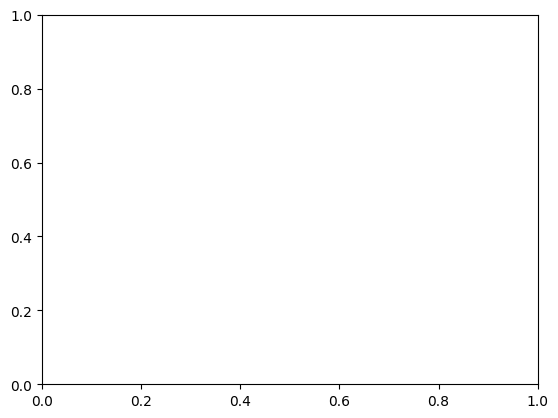

In [42]:
start=time.time()
grid_size = 64

fig = plt.figure()
x = gen_grid(grid_size, low=-2.0, high=2.0)

def animate(t):
    plt.cla()
    out = space_time_blending(sdf_sphere,sdf_box,np.array([t]), x, a0=1.0, a1=1.0, a2=1.0)
    im = plt.contour(out.reshape(grid_size, grid_size,grid_size)[:,:,grid_size//2], levels = [0.0])
    verts, faces, _, _ = skimage.measure.marching_cubes(sdf_sphere(grid).reshape(grid_size, grid_size, grid_size), level=0.0)
    plt.axis('equal')
    plt.axis("off")
    return verts
#space time blending
anim = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 1, 50), interval=50)
end=time.time()
anim.save("stb_morphing_translated.mp4",fps=20, writer="ffmpeg")
files.download("stb_morphing_translated.mp4")
print(end-start)

In [61]:
start=time.time()
grid_size = 64
grid = gen_grid(grid_size,-2.0,2.0)

# f1 and f2 are prob. distribution corresponding to f1 and f2
f1 = sample_and_normalize(sdf_sphere, grid, grid_size)
f2 = sample_and_normalize(sdf_octahedron, grid, grid_size)

A = np.array([f1,f2])

nb_images = 5
reg = 0.004

v1 = np.array((1, 0))
v2 = np.array((0, 1))

fig, axes = plt.subplots(1, nb_images, figsize=(7, 7))
plt.suptitle("Optimal Trasport")
cm = "Blues"

verts, faces, _, _ = skimage.measure.marching_cubes(sdf_sphere(grid).reshape(grid_size, grid_size, grid_size)
, level=0.0)

for i in range(nb_images):
    tx = float(i) / (nb_images - 1)

    weights = (1 - tx) * v1 + tx * v2

    if i == 0:
        axes[i].imshow(f1, cmap=cm)
    elif i == (nb_images - 1):
        axes[i].imshow(f2, cmap=cm)
    else:
        axes[i].imshow(
            ot.bregman.convolutional_barycenter2d(A, reg, weights), cmap=cm
        )
    axes[i].axis("off")

plt.tight_layout()
plt.show()
end=time.time()
print(end-start)

(262144, 3)
(262144,)
(262144, 3)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

(32768, 3)
(32768,)
(32768, 3)
(32768,)


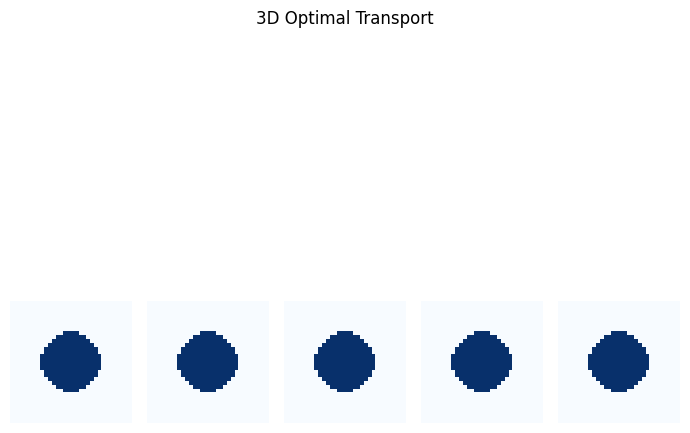

0.7975409030914307


In [69]:
start = time.time()
grid_size = 32
grid = gen_grid(grid_size, -2.0, 2.0)

f1 = sample_and_normalize(sdf_sphere, grid, grid_size)
f2 = sample_and_normalize(sdf_sphere, grid, grid_size)

A = np.array([f1, f2])

nb_images = 5
reg = 0.004

v1 = np.array((1, 0))
v2 = np.array((0, 1))

fig, axes = plt.subplots(1, nb_images, figsize=(7, 7))
plt.suptitle("3D Optimal Transport")
cm = "Blues"

for i in range(nb_images):
    tx = float(i) / (nb_images - 1)
    weights = (1 - tx) * v1 + tx * v2

    if i == 0:
        axes[i].imshow(f1[:, :, grid_size // 2], cmap=cm)
    elif i == (nb_images - 1):
        axes[i].imshow(f2[:, :, grid_size // 2], cmap=cm)
    else:
        f_ot = convolutional_barycenter3d(A, reg, weights)
        axes[i].imshow(f_ot[:, :, grid_size // 2], cmap=cm)

    axes[i].axis("off")

plt.tight_layout()
plt.show()
end=time.time()
print(end-start)

In [58]:
# === Space-Time Blending の SDF ===
def visualize_space_time_blending(f1, f2, t, grid_size=64, bounds=(-2, 2), output_file="output.png"):
    """
    Generate a 3D mesh using Space-Time Blending and render it using ray-tracing.

    Parameters:
        f1, f2: SDF functions
        t: Interpolation parameter (0 to 1)
        grid_size: Resolution of the SDF grid
        bounds: 3D space bounds (min, max)
        output_file: File to save the rendered image
    """
    # 1. 3D Grid を生成
    x = np.linspace(bounds[0], bounds[1], grid_size)
    y = np.linspace(bounds[0], bounds[1], grid_size)
    z = np.linspace(bounds[0], bounds[1], grid_size)
    X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

    grid = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    # 2. Space-Time Blending を適用 (3D SDF を取得)
    sdf_values = space_time_blending(f1, f2, np.array([t]), grid)
    sdf_values = sdf_values.reshape(grid_size, grid_size, grid_size)

    # 3. Marching Cubes で三角形メッシュを作成
    verts, faces, normals, _ = skimage.measure.marching_cubes(sdf_values, level=0.0)

    # 4. trimesh でメッシュを作成
    mesh = trimesh.Trimesh(vertices=verts, faces=faces, vertex_normals=normals)

    # 5. pyrender で Ray-Tracing 画像を生成
    scene = pyrender.Scene()
    scene.add(pyrender.Mesh.from_trimesh(mesh))

    # カメラ設定
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
    scene.add(camera, pose=np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 3],  # Z方向に移動
        [0, 0, 0, 1]
    ]))

    # ライト設定
    light = pyrender.DirectionalLight(color=np.ones(3), intensity=2.0)
    scene.add(light, pose=np.eye(4))

    # 画像レンダリング
    r = pyrender.OffscreenRenderer(800, 800)
    color, _ = r.render(scene)

    # 6. 画像を保存
    plt.imsave(output_file, color)

    print(f"Rendered image saved: {output_file}")

# === SDF 関数の定義 ===
def sdf_sphere(p, r=1.0):
    return np.sqrt(np.sum(p**2, axis=1)) - r

def sdf_box(p, b=np.array([1.0, 1.0, 1.0])):
    q = np.abs(p) - b
    return np.linalg.norm(np.maximum(q, 0.0), axis=1) + np.minimum(np.maximum(q[:,0], np.maximum(q[:,1], q[:,2])), 0.0)

# === 実行（t=0.5 の場合） ===
visualize_space_time_blending(sdf_sphere, sdf_box, t=0.5, output_file="blended_mesh.png")


NoSuchDisplayException: Cannot connect to "None"